<a href="https://colab.research.google.com/github/Stavroskiig/MLP-kNN-NC-CIFAR-100/blob/main/NN_1st_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Νευρωνικά Δίκτυα - Βαθιά Μάθηση**

1η Υποχρεωτική Εργασία


---
* **Στόχος**:
Ζητούμενο της εργασίας είναι να γραφεί πρόγραμμα σε οποιαδήποτε γλώσσα προγραμματισμού το οποίο να υλοποιεί ένα νευρωνικό δίκτυο πολυστρωματικού perceptron (το δίκτυο μπορεί να είναι πλήρως συνδεδεμένο ή συνελικτικό ή συνδυασμός) που θα εκπαιδεύεται με τον αλγόριθμο back-propagation. Το NN αυτό θα
εκπαιδευτεί για να επιλύει οποιοδήποτε πρόβλημα κατηγοριοποίησης πολλών κλάσεων εκτός MNIST.

* **Γλώσσα**:
Επιλέγω να εργαστώ σε Python χρησιμοποιώντας την βιβλιοθήκη Keras, η οποία λειτουργεί ως διεπαφή για τη βιβλιοθήκη TensorFlow.

* **Βάση Δεδομένων**:
Για την εκπαίδευση και την κατηγοριοποίηση αποφάσισα να χρησιμοποιήσω την βάση δεδομένων CIFAR-100 που υπάρχει στην παρακάτω διεύθυνση:
https://www.cs.toronto.edu/~kriz/cifar.html


---



# Φόρτωση του dataset

1.   **Πρώτος τρόπος**

Αρχικά θα φορτώσω το σύνολο δεδομένων στο colab. Κατεβάζοντας τον αντίστοιχο φάκελο για την Python από το παραπάνω link, βρίσκω μέσα το αρχείο train, όπως και το test. Κάθε ένα από αυτά τα αρχεία είναι ένα Python "pickled" αντικείμενο που σχηματίστηκε με το cPickle. Με την παρακάτω συνάρτηση μπορώ να ανοίξω ένα τέτοιο αρχείο και να επιστρέψω ένα dictionary:

In [ ]:
def unpickle(file):
  import pickle
  with open(file, 'rb') as fo:
    dict = pickle.load(fo, encoding='bytes')
  return dict

Αποθήκευσα το σύνολο δεδομένων στο Google Drive, οπότε με τον παρακάτω τρόπο μπορώ να το φορτώσω και εδώ, δίνοντας άδεια στο Colab να επικοινωνεί με το Drive του λογαρισμού.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Κάνω χρήση της προηγούμενης συνάρτησης για να πάρω το λεξικό.

In [ ]:
cifar100 = unpickle('/content/drive/MyDrive/cifar-100-python/train')

2.   **Δεύτερος τρόπος**

Αυτός ο τρόπος είναι ο απλούστερος, απλά δείχνω και τους δύο χάριν πληρότητας. Ουσιαστικά παίρνω το dataset από την keras. Βεβαίως απαιτείται πρώτα να εισάγω την TensorFLow.



In [ ]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 4s 0us/step


Αυτό μου επιστρέφει:
* **x_train**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (50000, 32, 32, 3), που περιέχουν τα δεδομένα εκπαίδευσης (train). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_train**: uint8 NumPy πίνακας ετικετών (labels) (ακέραιοι του εύρους 0-99) με shape (50000, 1) για τα δεδομένα εκπαίδευσης (train).

* **x_test**: uint8 NumPy πίνακας δεδομένων εικόνας με shapes (10000, 32, 32, 3), που περιέχουν τα δεδομένα δοκιμής (test). Οι τιμές pixel κυμαίνονται από 0 έως 255.

* **y_tes**t: uint8 NumPy πίνακας ετικετών (ακέραιοι στο εύρος 0-99) με shapes (10000, 1) για τα δεδομένα δοκιμής (test).

# Το CIFAR-100 Dataset

Κάπου έδω θα μελετήσω λίγο το dataset, την δομή του και το περιεχόμενό του. Για αυτό το σκοπό θα χρησιμοποιήσω την πρώτη μέθοδο φόρτωσής του. Γενικά, έχει 100 κλάσεις που περιέχει 600 εικόνες η καθεμιά. Υπάρχουν 500 εικόνες εκπαίδευσης και 100 εικόνες testing ανά κλάση. Οι 100 classes στο CIFAR-100 είναι χωρισμένες σε 20 υπερκλάσεις (superclasses). Κάθε εικόνα έχει μια "fine" ετικέτα (η κλάση στην οποία ανήκει) και μια "coarse" ετικέτα (η superclass στην οποία ανήκει).

In [ ]:
print(type(cifar100))
print(len(cifar100))

<class 'dict'>
5


Βλέπω πως το σύνολο cifar100 είναι ένα λεξικό με 5 κλειδιά. Τώρα θα τυπώσω τα κλειδιά αυτά.

In [ ]:
print("Keys:", list(cifar100.keys()))

Keys: [b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data']


Θα τυπώσω και τις τιμές.

In [ ]:
for key, value in cifar100.items():
    print(key, ":", value)

b'filenames' : [b'bos_taurus_s_000507.png', b'stegosaurus_s_000125.png', b'mcintosh_s_000643.png', b'altar_boy_s_001435.png', b'cichlid_s_000031.png', b'phone_s_002161.png', b'car_train_s_000043.png', b'beaker_s_000604.png', b'fog_s_000397.png', b'rogue_elephant_s_000421.png', b'computer_keyboard_s_000757.png', b'willow_tree_s_000645.png', b'sunflower_s_000549.png', b'palace_s_000759.png', b'adriatic_s_001782.png', b'computer_keyboard_s_001277.png', b'bike_s_000682.png', b'wolf_pup_s_001323.png', b'squirrel_s_002467.png', b'sea_s_000678.png', b'shrew_s_002233.png', b'pine_tree_s_000087.png', b'rose_s_000373.png', b'surveillance_system_s_000769.png', b'pine_s_001533.png', b'table_s_000897.png', b'opossum_s_001237.png', b'quercus_alba_s_000257.png', b'leopard_s_000414.png', b'possum_s_002195.png', b'bike_s_000127.png', b'balmoral_castle_s_000361.png', b'acer_saccharinum_s_000646.png', b'lapin_s_000916.png', b'chimp_s_001419.png', b'clock_s_002291.png', b'streetcar_s_000663.png', b'male_c

Ας δούμε τώρα από τι αποτελείται το λεξικό.
* **b'filenames'**: Περιέχει τα ονόματα των εικόνων.
* **b'batch_label'**: Περιέχει την ονομασία του τωρινού batch εκπαίδευσης.
* **b'fine_labels'**: Περιέχει την κλάση που ανήκει κάθε εικόνα.
* **b'coarse_labels'**: Περιέχει την superclass που ανήκει κάθε εικόνα.
* **b'data'**: Περιέχει τις εικόνες υπό την μορφή συνόλου pixels.

Το 'b' σημαίνει ότι οι συμβολοσειρές είναι σε μορφή byte και όχι σε μορφή χαρακτήρων Unicode.

In [ ]:
cifar100[b'data']

array([[255, 255, 255, ...,  10,  59,  79],
       [255, 253, 253, ..., 253, 253, 255],
       [250, 248, 247, ..., 194, 207, 228],
       ...,
       [248, 240, 236, ..., 180, 174, 205],
       [156, 151, 151, ..., 114, 107, 126],
       [ 31,  30,  31, ...,  72,  69,  67]], dtype=uint8)

In [ ]:
cifar100[b'data'].shape

(50000, 3072)

Επιβεβαιώνω πως έχω 50.000 εικόνες εκπαίδευσης και 3072 τιμές pixel που προκύπτουν από τα τρία κανάλια RGB με 3072/3=1024 το κάθενα. Κάθε κανάλι είναι ένας πίνακας με 32x32=1024 τιμές. Οι πρώτες 1024 καταχωρήσεις περιέχουν τις τιμές του κόκκινου (R) καναλιού, οι επόμενες 1024 το πράσινο (G) και οι τελευταίες 1024 το μπλε (B). Η εικόνα αποθηκεύεται με τέτοια σειρά, έτσι ώστε οι πρώτες 32 καταχωρήσεις του πίνακα να είναι οι τιμές του κόκκινου καναλιού της πρώτης σειράς της εικόνας.

In [ ]:
cifar100[b'data'][0]

array([255, 255, 255, ...,  10,  59,  79], dtype=uint8)

In [ ]:
cifar100[b'data'][0].shape

(3072,)

Αυτές οι τίμες pixels είναι ουσιαστικά η πρώτη εικόνα του dataset. Ας την προβάλω κιόλας. Για αυτό με την εντολή `image = image.reshape(3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel. Στην συνέχεια προβάλω την εικόνα, αφού αλλάξω την σειρά όπως θέλει η `matplotlib`.

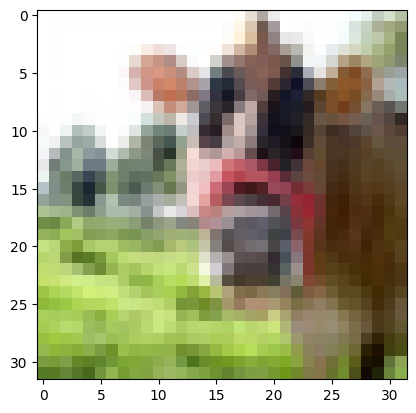

In [ ]:
image = cifar100[b'data'][0]
image = image.reshape(3,32,32).transpose(1,2,0)

from matplotlib import pyplot as plt
plt.imshow(image)

Τώρα θα εφαρμόσω τον ίδιο μετασχηματισμό για όλο το σύνολο. Με την εντολη `data = data.reshape(len(data), 3, 32, 32)` αναδιαμορφώνω τα δεδομένα της εικόνας ως τρία κανάλια (R, G, B) και μέγεθος 32x32 pixel, ακριβώς όπως πριν. Πλέον ο πίνακας `data` είναι της μορφής `[num_images, num_channels, height, width] `. Εγώ όμως θέλω την μορφή `[num_images, height, width, num_channels]` ώστε να το δεχτεί σωστά η `matplotlib`. Οπότε με την εντολή `.transpose(0,2,3,1)` αλλάζω αυτή την σειρά.


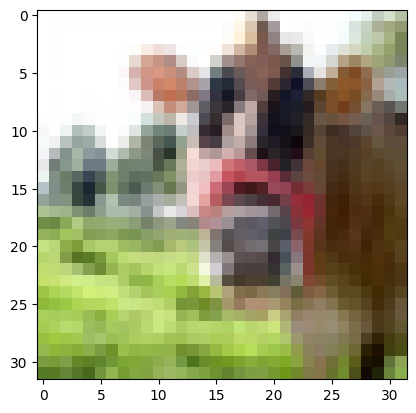

In [ ]:
data = cifar100[b'data']
data = data.reshape(len(data),3,32,32).transpose(0,2,3,1)
plt.imshow(data[0])

Έλεγξα ότι η αναδιαμόρφωση έγινε σωστά. Τώρα θα προβάλω κάποια πλέγματα εικόνων.

<function matplotlib.pyplot.show(close=None, block=None)>

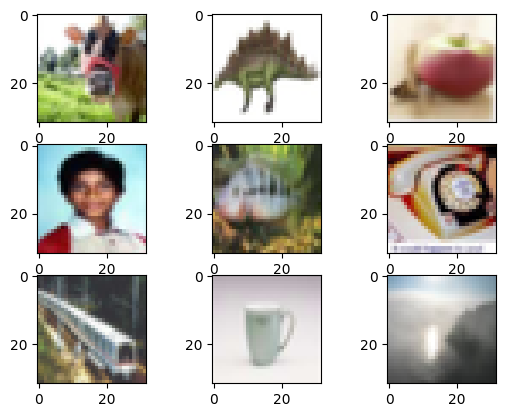

In [ ]:
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.imshow(data[i])
plt.show

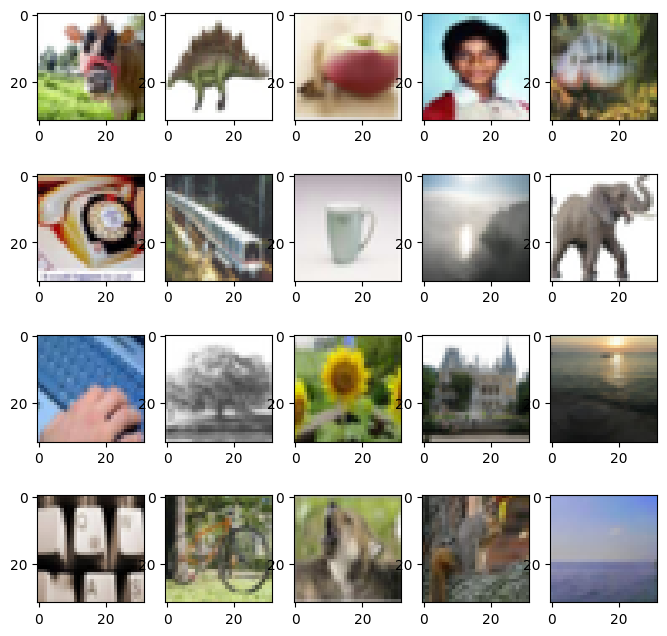

In [ ]:
columns = 5
rows = 4
fig = plt.figure(figsize=(8,8))
for i in range(1, columns*rows+1):
  fig.add_subplot(rows,columns,i)
  plt.imshow(data[i-1])
plt.show()

# Προεπεξεργασία του CIFAR-100

Αρχικά, θα το φορτώσω με την δεύτερη μέθοδο αυτλη την φορά, ώστε στη συνέχεια να προχωρήσω με τα μοντέλα νευρωνικών δικτύων.

In [1]:
import tensorflow as tf

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data(label_mode="fine")

169001437/169001437 [==============================] - 3s 0us/step


Θα δω τα shapes των συνόλων. Τα `x` σύνολα περιλαμβάνουν τις εικόνες, ενώ τα `y` τις ετικέτες.

In [ ]:
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

x_train: (50000, 32, 32, 3) y_train: (50000, 1)
x_test: (10000, 32, 32, 3) y_test: (10000, 1)


* Τα `x_train` και `x_test` έχουν το shape: (πλήθος εικόνων, ύψος, πλάτος, πλήθος καναλιών).
* Τα `y_train` και `y_test` είναι 2D πίνακες με shape: (πλήθος εικόνων, 1)

Μετατρέπω τα σύνολα σε `float32`.

In [2]:
import numpy as np

x_train, x_test = np.array(x_train, dtype=np.float32), np.array(x_test, dtype=np.float32)

Θα κάνω flatten τις εικόνες από 3D σε διανύσματα 1D.

In [3]:
number_features = 3072

x_train = x_train.reshape([-1, number_features])
x_test = x_test.reshape([-1, number_features])

print("x_train:", x_train.shape, "x_test:", x_test.shape)

x_train: (50000, 3072) x_test: (10000, 3072)


Θα τις κανονικοποιήσω στο εύρος [0,1].

In [4]:
x_train = x_train/255.0
x_test = x_test/255.0

Κρατώ τον αριθμό των κλάσεων και των υπερκλάσεων για το μέλλον.

In [ ]:
number_classes = 100
number_superclasses = 20

Θα εφαρμόσω one-hot encoding, η οποία είναι μια μέθοδος που δέχεται ως είσοδο έναν πίνακα ακεραίων ή strings και συγκεκριμένα τα labels. Τα κωδικοποιεί χρησιμοποιώντας ένα σχήμα κωδικοποίησης one-hot (γνωστό και ως «one-of-K» ή «dummy»). Αυτό δημιουργεί μια binary στήλη για κάθε κατηγορία και επιστρέφει έναν αραιό πίνακα ή έναν πυκνό πίνακα (ανάλογα με την παράμετρο sparse_output). Αναμένω η έξοδος να είναι της μορφής που παρουσιάζεται στην εικόνα. Η συγκεκριμένη τεχνική πάντως δεν επηρεάζει την απόδοση αυτών των classifiers, παρά μόνο των νευρωνικών δικτύων που θα υλοποιηθούν αργότερα.
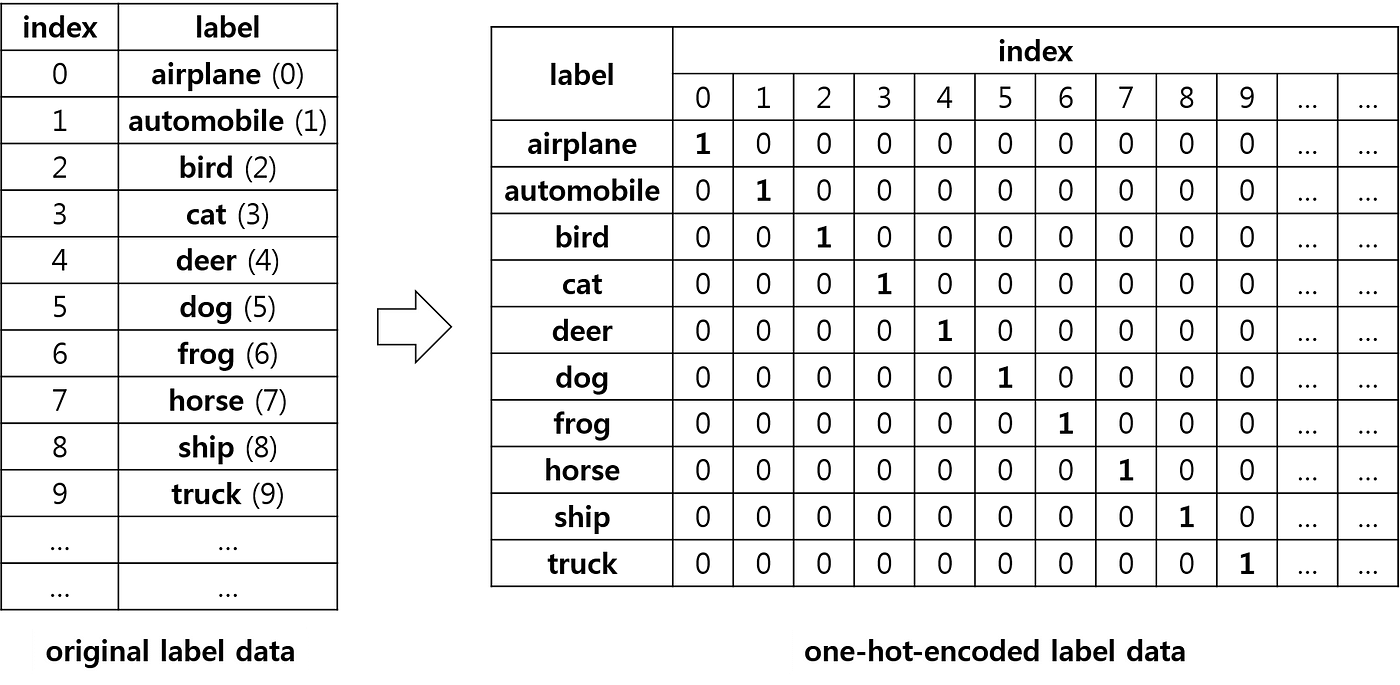

In [11]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.fit_transform(y_test)

# k-NN Models

Εισάγω από την κατάλληλη βιβλιοθήκη (`sklearn`) τον κατηγοριοποιητή πλησιέστερου γείτονα.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Αρχικά φτιάχνω τον κατηγοριοποιητή ενός κοντινού γείτονα με `p=2`, δηλαδή επιλέγοντας την ευκλείδια απόσταση ως υπερπαράμετρο της μετρικής Minkowski.

In [ ]:
knn_1 = KNeighborsClassifier(n_neighbors=1, p=2)

Εισάγω και την βιβλιοθήκη `time` για την χρονομέτρηση της εκπαίδευσης και της αξιολόγησης.

In [ ]:
import time

In [ ]:
starting_time = time.time()

knn_1.fit(x_train, y_train)

ending_time = time.time()
print("Training time: {}s\n".format(ending_time-starting_time))


Training time: 0.08588361740112305s



/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
starting_time = time.time()

score = knn_1.score(x_test, y_test)

ending_time = time.time()
print("Testing time: {}s\n".format(ending_time-starting_time))

Testing time: 129.09973907470703s



In [ ]:
print("For the 1-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

For the 1-NN classifier with Euclidean distance metric used accuracy is: 0.1755


Οπότε πετυχαίνω **0.1755** ακρίβεια, δηλαδή αρκετά χαμηλή σε 129.1 δευτερόλεπτα. Τώρα θα δοκιμάσω αν αλλάζει κάτι ελέγχοντας τρεις γείτονες.

In [ ]:
knn_3 = KNeighborsClassifier(n_neighbors=3, p=2)

starting_time = time.time()

knn_3.fit(x_train, y_train)

ending_time = time.time()
print("Training time: {}s\n".format(ending_time-starting_time))

starting_time = time.time()

score = knn_3.score(x_test, y_test)

ending_time = time.time()
print("Testing time: {}s\n".format(ending_time-starting_time))

print("For the 3-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.36505579948425293s

Testing time: 129.57000398635864s

For the 3-NN classifier with Euclidean distance metric used accuracy is: 0.1479


Παρατηρώ πως ναι μεν χρειάζεται παραπάνω χρόνο όπως αναμενόταν, αλλά η ακρίβεια έπεσε στο **0.1479**.

# Nearest Centroid Models

Τώρα θα τεστάρω τον κατηγοριοποιητή `NearestCentroid`, αρχικά με μετρική την Ευκλείδια απόσταση.

In [ ]:
from sklearn.neighbors import NearestCentroid

In [ ]:
ncc = NearestCentroid(metric='euclidean')

start = time.time()

ncc.fit(x_train, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 0.24904704093933105s

Testing time: 0.4252936840057373s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.1004


Παρατηρώ πως είναι πολύ γρήγορο αλλά με χειρότερη ακρίβεια σε σχέση με τα k-NN. Θα δοκιμάσω να αλλάξω την μετρική στην απόσταση Μανχάταν.

In [ ]:
ncc = NearestCentroid(metric='manhattan')

start = time.time()

ncc.fit(x_train, y_train)

end = time.time()
print("Training time: {}s\n".format(end-start))

start = time.time()

score = ncc.score(x_test, y_test)

end = time.time()
print("Testing time: {}s\n".format(end-start))

print("For the Nearest Centroid classifier with L2 distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training time: 5.28780460357666s

Testing time: 4.8371288776397705s

For the Nearest Centroid classifier with L2 distance metric used accuracy is: 0.1045


Τώρα είναι πιο αργό και ελάχιστα πιο ακριβές από πριν.

Γενικά, βλέπω πως έχω πετύχει αρκετά χαμηλή ακριβεία. Για αυτό το λόγο θα χρησιμοποιήσω τις μεθόδους των feature extraction και feature selection για να την βελτιώσω.

# Feature extraction

Η εξαγωγή χαρακτηριστικών (feature extraction) είναι η διαδικασία μετατροπής και μείωσης των πληροφοριών που περιέχονται σε raw data, όπως εικόνες ή κείμενο, σε μια πιο περιεκτική μορφή. Σε δεδομένα εικόνας, η εξαγωγή χαρακτηριστικών συχνά γίνεται με την μέθοδο PCA για τη μείωση της διάστασης, καθιστώντας το κατάλληλο για χρήση σε μοντέλα μηχανικής μάθησης. Βοηθά στη βελτίωση της αποδοτικότητας του μοντέλου και μπορεί να αποκαλύψει μοτίβα ή νέα χαρακτηριστικά στα δεδομένα.

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.90)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

Θέλω το PCA να διατηρήσει τα κύρια στοιχεία που καλύπτουν τουλάχιστον το 90% της διακύμανσης στα δεδομένα, εξού και `n_components=0.90`. Μετά εφαρμόζω το PCA στα δεδομένα και τα μετασχηματίζω.

Ας δούμε την μεταβολή του αριθμού των features.

In [ ]:
print("Number of features before PCA: ", x_train.shape[1])
print("Number of features after PCA: ", x_train_pca.shape[1])

Number of features before PCA:  3072
Number of features after PCA:  87


Από 3072 μειώθηκαν στα 87.

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import time

knn_classifier = KNeighborsClassifier(n_neighbors=1, p=2)

starting_time = time.time()

knn_classifier.fit(x_train_pca, y_train_encoded)

ending_time = time.time()
print("Training time: {}s\n".format(ending_time-starting_time))

starting_time = time.time()

score = knn_classifier.score(x_test_pca, y_test_encoded)

ending_time = time.time()
print("Testing time: {}s\n".format(ending_time-starting_time))

print("For the 1-NN classifier with Euclidean distance metric used accuracy is: {}".format(score))

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Training time: 0.02039337158203125s

Testing time: 11.164913654327393s

For the 1-NN classifier with Euclidean distance metric used accuracy is: 0.1944
